In [1]:
!mkdir data && cd data && wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip /data/data_road.zip 

--2018-06-10 15:04:04--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.48
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470992343 (449M) [application/zip]
Saving to: ‘data_road.zip’

data_road.zip       100%[===================>] 449.17M  15.6MB/s    in 37s     

2018-06-10 15:04:42 (12.1 MB/s) - ‘data_road.zip’ saved [470992343/470992343]

/data/data_road.zip: Scheme missing.
FINISHED --2018-06-10 15:04:42--
Total wall clock time: 38s
Downloaded: 1 files, 449M in 37s (12.1 MB/s)


In [11]:
!ls data/data_road

testing  training


In [0]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1
! unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1

In [0]:
!cd data && unzip data_road.zip  > /dev/null 2>&1

In [0]:
!pip install imageio tqdm  > /dev/null 2>&1

In [0]:
from google.colab import auth, files
auth.authenticate_user()
project_id = 'data4democracy-wwymak-explore'

In [6]:
!gcloud config set project {project_id}

Updated property [core/project].


In [0]:
LOG_DIR = 'tensorboard_graphs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [15]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://0fc8f3ef.ngrok.io


In [0]:
import re
import random
import numpy as np
import os.path
import scipy.misc
import shutil
import zipfile
import time
import tensorflow as tf
from glob import glob
from urllib.request import urlretrieve
from tqdm import tqdm

import tensorflow as tf

import sys
from copy import deepcopy
from unittest import mock

from PIL import Image
from skimage.transform import resize
from imageio import imread

from distutils.version import LooseVersion
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [0]:
# helper functions

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

def safe_mkdir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

def maybe_download_pretrained_vgg(data_dir):
    """
    Download and extract pretrained vgg model if it doesn't exist
    :param data_dir: Directory to download the model to
    """
    vgg_filename = 'vgg.zip'
    vgg_path = os.path.join(data_dir, 'vgg')
    vgg_files = [
        os.path.join(vgg_path, 'variables/variables.data-00000-of-00001'),
        os.path.join(vgg_path, 'variables/variables.index'),
        os.path.join(vgg_path, 'saved_model.pb')]

    missing_vgg_files = [vgg_file for vgg_file in vgg_files if not os.path.exists(vgg_file)]
    if missing_vgg_files:
        # Clean vgg dir
        if os.path.exists(vgg_path):
            shutil.rmtree(vgg_path)
        os.makedirs(vgg_path)

        # Download vgg
        print('Downloading pre-trained vgg model...')
        with DLProgress(unit='B', unit_scale=True, miniters=1) as pbar:
            urlretrieve(
                'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip',
                os.path.join(vgg_path, vgg_filename),
                pbar.hook)

        # Extract vgg
        print('Extracting model...')
        zip_ref = zipfile.ZipFile(os.path.join(vgg_path, vgg_filename), 'r')
        zip_ref.extractall(data_dir)
        zip_ref.close()

        # Remove zip file to save space
        os.remove(os.path.join(vgg_path, vgg_filename))


def gen_batch_function(data_folder, image_shape):
    """
    Generate function to create batches of training data
    :param data_folder: Path to folder that contains all the datasets
    :param image_shape: Tuple - Shape of image
    :return:
    """
    def get_batches_fn(batch_size):
        """
        Create batches of training data
        :param batch_size: Batch Size
        :return: Batches of training data
        """
        image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
        label_paths = {
            re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
            for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}
        background_color = np.array([255, 0, 0])

        random.shuffle(image_paths)
        for batch_i in range(0, len(image_paths), batch_size):
            images = []
            gt_images = []
            for image_file in image_paths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
                gt_image = scipy.misc.imresize(scipy.misc.imread(gt_image_file), image_shape)

                gt_bg = np.all(gt_image == background_color, axis=2)
                gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
                gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)

                images.append(image)
                gt_images.append(gt_image)

            yield np.array(images), np.array(gt_images)
    return get_batches_fn


def gen_test_output(sess, logits, keep_prob, image_pl, data_folder, image_shape):
    """
    Generate test output using the test images
    :param sess: TF session
    :param logits: TF Tensor for the logits
    :param keep_prob: TF Placeholder for the dropout keep robability
    :param image_pl: TF Placeholder for the image placeholder
    :param data_folder: Path to the folder that contains the datasets
    :param image_shape: Tuple - Shape of image
    :return: Output for for each test image
    """
    for image_file in glob(os.path.join(data_folder, 'image_2', '*.png')):
        image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)

        im_softmax = sess.run(
            [tf.nn.softmax(logits)],
            {keep_prob: 1.0, image_pl: [image]})
        im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
        segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
        mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
        mask = scipy.misc.toimage(mask, mode="RGBA")
        street_im = scipy.misc.toimage(image)
        street_im.paste(mask, box=None, mask=mask)

        yield os.path.basename(image_file), np.array(street_im)


def save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image):
    # Make folder for current run
    output_dir = os.path.join(runs_dir, str(time.time()))
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    # Run NN on test images and save them to HD
    print('Training Finished. Saving test images to: {}'.format(output_dir))
    image_outputs = gen_test_output(
        sess, logits, keep_prob, input_image, os.path.join(data_dir, 'data_road/testing'), image_shape)
    for name, image in image_outputs:
        scipy.misc.imsave(os.path.join(output_dir, name), image)

In [0]:
# project tests
def test_safe(func):
    """
    Isolate tests
    """
    def func_wrapper(*args):
        with tf.Graph().as_default():
            result = func(*args)
        print('Tests Passed')
        return result

    return func_wrapper


def _prevent_print(function, params):
    sys.stdout = open(os.devnull, "w")
    function(**params)
    sys.stdout = sys.__stdout__


def _assert_tensor_shape(tensor, shape, display_name):
    assert tf.assert_rank(tensor, len(shape), message='{} has wrong rank'.format(display_name))

    tensor_shape = tensor.get_shape().as_list() if len(shape) else []

    wrong_dimension = [ten_dim for ten_dim, cor_dim in zip(tensor_shape, shape)
                       if cor_dim is not None and ten_dim != cor_dim]
    assert not wrong_dimension, \
        '{} has wrong shape.  Found {}'.format(display_name, tensor_shape)


class TmpMock(object):
    """
    Mock a attribute.  Restore attribute when exiting scope.
    """
    def __init__(self, module, attrib_name):
        self.original_attrib = deepcopy(getattr(module, attrib_name))
        setattr(module, attrib_name, mock.MagicMock())
        self.module = module
        self.attrib_name = attrib_name

    def __enter__(self):
        return getattr(self.module, self.attrib_name)

    def __exit__(self, type, value, traceback):
        setattr(self.module, self.attrib_name, self.original_attrib)


@test_safe
def test_load_vgg(load_vgg, tf_module):
    with TmpMock(tf_module.saved_model.loader, 'load') as mock_load_model:
        vgg_path = ''
        sess = tf.Session()
        test_input_image = tf.placeholder(tf.float32, name='image_input')
        test_keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        test_vgg_layer3_out = tf.placeholder(tf.float32, name='layer3_out')
        test_vgg_layer4_out = tf.placeholder(tf.float32, name='layer4_out')
        test_vgg_layer7_out = tf.placeholder(tf.float32, name='layer7_out')

        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, vgg_path)

        assert mock_load_model.called, \
            'tf.saved_model.loader.load() not called'
        assert mock_load_model.call_args == mock.call(sess, ['vgg16'], vgg_path), \
            'tf.saved_model.loader.load() called with wrong arguments.'

        assert input_image == test_input_image, 'input_image is the wrong object'
        assert keep_prob == test_keep_prob, 'keep_prob is the wrong object'
        assert vgg_layer3_out == test_vgg_layer3_out, 'layer3_out is the wrong object'
        assert vgg_layer4_out == test_vgg_layer4_out, 'layer4_out is the wrong object'
        assert vgg_layer7_out == test_vgg_layer7_out, 'layer7_out is the wrong object'


@test_safe
def test_layers(layers):
    num_classes = 2
    vgg_layer3_out = tf.placeholder(tf.float32, [None, None, None, 256])
    vgg_layer4_out = tf.placeholder(tf.float32, [None, None, None, 512])
    vgg_layer7_out = tf.placeholder(tf.float32, [None, None, None, 4096])
    layers_output = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)

    _assert_tensor_shape(layers_output, [None, None, None, num_classes], 'Layers Output')


@test_safe
def test_optimize(optimize):
    num_classes = 2
    shape = [2, 3, 4, num_classes]
    layers_output = tf.Variable(tf.zeros(shape))
    correct_label = tf.placeholder(tf.float32, [None, None, None, num_classes])
    learning_rate = tf.placeholder(tf.float32)
    logits, train_op, cross_entropy_loss, iou_op = optimize(layers_output, correct_label, learning_rate, num_classes)

    _assert_tensor_shape(logits, [2*3*4, num_classes], 'Logits')

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run([train_op], {correct_label: np.arange(np.prod(shape)).reshape(shape), learning_rate: 10})
        test, loss = sess.run([layers_output, cross_entropy_loss], {correct_label: np.arange(np.prod(shape)).reshape(shape)})

    assert test.min() != 0 or test.max() != 0, 'Training operation not changing weights.'


@test_safe
def test_train_nn(train_nn):
    epochs = 1
    batch_size = 2

    def get_batches_fn(batach_size_parm):
        shape = [batach_size_parm, 2, 3, 3]
        return np.arange(np.prod(shape)).reshape(shape)

    train_op = tf.constant(0)
    iou_op = tf.Variable(np.array([[1,0], [0,1]]))
    cross_entropy_loss = tf.constant(10.11)
    input_image = tf.placeholder(tf.float32, name='input_image')
    correct_label = tf.placeholder(tf.float32, name='correct_label')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    with tf.Session() as sess:
        parameters = {
            'sess': sess,
            'epochs': epochs,
            'batch_size': batch_size,
            'get_batches_fn': get_batches_fn,
            'train_op': train_op,
            'cross_entropy_loss': cross_entropy_loss,
            'input_image': input_image,
            'correct_label': correct_label,
            'keep_prob': keep_prob,
            'learning_rate': learning_rate,
#             'iou_op': iou_op
        }
        _prevent_print(train_nn, parameters)


@test_safe
def test_for_kitti_dataset(data_dir):
    kitti_dataset_path = os.path.join(data_dir, 'data_road')
    training_labels_count = len(glob(os.path.join(kitti_dataset_path, 'training/gt_image_2/*_road_*.png')))
    training_images_count = len(glob(os.path.join(kitti_dataset_path, 'training/image_2/*.png')))
    testing_images_count = len(glob(os.path.join(kitti_dataset_path, 'testing/image_2/*.png')))

    assert not (training_images_count == training_labels_count == testing_images_count == 0),\
        'Kitti dataset not found. Extract Kitti dataset in {}'.format(kitti_dataset_path)
    assert training_images_count == 289, 'Expected 289 training images, found {} images.'.format(training_images_count)
    assert training_labels_count == 289, 'Expected 289 training labels, found {} labels.'.format(training_labels_count)
    assert testing_images_count == 290, 'Expected 290 testing images, found {} images.'.format(testing_images_count)

In [0]:
l2_weight_decay = 1e-5
reg_const = 1e-5
# learning_rate_val = 0.01
learning_rate_val = 0.001
keep_prob_val = 0.5
num_epochs = 40
batch_size = 8
num_classes = 2
image_shape = (160, 576)


data_dir = './data'
runs_dir = './runs'
train_dir = './data/data_road/training'
vgg_path = './data/vgg'

freeze_vgg_top = True

tf_graph_dir = 'tensorboard_graphs/fcn_lr-{}_kp-{}_batch-{}_regconst-{}_vggfrozen-{}'.format(learning_rate_val, keep_prob_val,
                                                                                batch_size, reg_const, freeze_vgg_top)
checkpoint_dir = 'checkpoints/fcn_lr-{}_kp-{}_batch-{}_regconst-{}_vggfrozen-{}'.format(learning_rate_val, keep_prob_val,
                                                                                batch_size, reg_const, freeze_vgg_top)

def load_vgg(sess, vgg_path, freeze_vgg_top=False):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    model = tf.saved_model.loader.load(
        sess,
        [vgg_tag],
        vgg_path
    )

    graph = tf.get_default_graph()
    with tf.name_scope("vgg_base"):
        image_input = graph.get_tensor_by_name(vgg_input_tensor_name)
        keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
        layer3 = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
        layer4 = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
        layer7 = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    

    if freeze_vgg_top:
        layer7 = tf.stop_gradient(layer7)
        layer4 = tf.stop_gradient(layer4)
        layer3 = tf.stop_gradient(layer3)

    tf.summary.image('image', image_input)

    return image_input, keep_prob, layer3, layer4, layer7

# test_load_vgg(load_vgg, tf)



def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    with tf.name_scope("decoder"):
        layer7_conv1x1 = tf.layers.conv2d(vgg_layer7_out, num_classes,
                                          kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_weight_decay),
                                          kernel_size=1,
                                          strides=1,
                                          # padding='SAME',
                                          name="layer7_conv1x1")

        layer8_upsample = tf.layers.conv2d_transpose(layer7_conv1x1, vgg_layer4_out.get_shape().as_list()[-1],
                                                     kernel_size=4,
                                                     strides=2,
                                                     kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_weight_decay),
                                                     padding='SAME',
                                                     name="layer8_upsample")

        layer9_skip = tf.add(layer8_upsample, vgg_layer4_out, name="layer9_skip")

        layer10_upsample = tf.layers.conv2d_transpose(layer9_skip, vgg_layer3_out.get_shape().as_list()[-1],
                                                     kernel_size=4,
                                                     strides=2,
                                                     kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_weight_decay),
                                                     padding='SAME',
                                                     name="layer10_upsample")
        layer11_skip = tf.add(layer10_upsample, vgg_layer3_out, name="layer11_skip")

        layer12_conv1x1 = tf.layers.conv2d_transpose(layer11_skip, num_classes,
                                                     kernel_size=16,
                                                     strides=8,
                                                     padding='SAME',
                                                     name="layer12_conv1x1")
        tf.summary.histogram('layer7_conv1x1', layer7_conv1x1)
        
        tf.summary.histogram('layer7_conv1x1', layer7_conv1x1)
        tf.summary.histogram('layer8_upsample', layer8_upsample)
        tf.summary.histogram('layer9_skip', layer9_skip)
        tf.summary.histogram('layer10_upsample', layer10_upsample)
        tf.summary.histogram('layer11_skip', layer11_skip)
        tf.summary.histogram('layer12_conv1x1', layer12_conv1x1)

        return layer12_conv1x1

# test_layers(layers)


def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    logits = tf.reshape(nn_last_layer, (-1, num_classes), name='logits')
    labels = tf.reshape(correct_label, (-1, num_classes), name='ground_truth')
    probabilities = tf.nn.softmax(logits, name='logits_to_prediction')
    predictions = tf.argmax(probabilities, -1)
    print(probabilities.get_shape().as_list(), labels.get_shape().as_list(), predictions.get_shape().as_list())
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels),
                                        name='xent_loss')
    regularisation_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    regulatisation_constant = reg_const
    
    cross_entropy_loss = cross_entropy_loss + regulatisation_constant * sum(regularisation_losses)
    mean_IOU, mean_IOU_update = tf.contrib.metrics.streaming_mean_iou(predictions=predictions, labels=tf.argmax(labels, -1),
                                                                      num_classes=num_classes)

    tf.summary.scalar("loss", cross_entropy_loss)
    tf.summary.scalar("mean_iou", mean_IOU)

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy_loss, name='train_op')

    return logits, optimizer, cross_entropy_loss, mean_IOU_update



# test_optimize(optimize)


def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    
    #saver for stashing checkpoints
    saver = tf.train.Saver(allow_empty=True)

    tfboard_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter(tf_graph_dir, graph=sess.graph)
    writer.add_graph(sess.graph)

#     ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
#     if ckpt and ckpt.model_checkpoint_path:
#         saver.restore(sess, ckpt.model_checkpoint_path)
    step = 0
    for epoch in tqdm(range(epochs)):

        total_loss = 0
        for imgs, gt_labels in get_batches_fn(batch_size):
            # only run the summary op every 10 steps to reduce computation
            if step % 10:
                _, loss, summary = sess.run([train_op, cross_entropy_loss, tfboard_summary], feed_dict={
                    input_image: imgs,
                    correct_label: gt_labels,
                    keep_prob: keep_prob_val,
                    learning_rate: learning_rate_val})
                writer.add_summary(summary, global_step=step)
            else:
                _, loss = sess.run([train_op, cross_entropy_loss], feed_dict={
                    input_image: imgs,
                    correct_label: gt_labels,
                    keep_prob: keep_prob_val,
                    learning_rate: learning_rate_val})

            step += 1
            total_loss += loss
        print("loss: ", loss, " step: ", step, " epoch: ", epoch)
        #save a checkpoint per epoch
        saver.save(sess, checkpoint_dir, global_step=step)


# test_train_nn(train_nn)


def run():
    test_for_kitti_dataset(data_dir)

    safe_mkdir('checkpoints')
    safe_mkdir('tensorboard_graphs')

    # clear out the graph from previous runs
    tf.reset_default_graph()

    # Download pretrained vgg model
    maybe_download_pretrained_vgg(data_dir)
    # define data generator
    get_batches_fn = gen_batch_function(train_dir, image_shape)

    with tf.Session() as sess:
        # input placeholders
        learning_rate = tf.placeholder(tf.float32)
        correct_label = tf.placeholder(tf.float32, shape=(None, image_shape[0], image_shape[1], num_classes))
        keep_prob = tf.placeholder(tf.float32)


        # loading the pretrained vgg16 backbone
        image_input, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(sess, vgg_path, freeze_vgg_top)
        #decoder construction
        nn_last_layer = layers(layer3_out, layer4_out, layer7_out, num_classes)
        # get the training op and the output
        logits, optimizer, loss, iou_op = optimize(nn_last_layer, correct_label, learning_rate, num_classes)

        # initialise variabes
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        # Train fcn network
        train_nn(sess, num_epochs, batch_size, get_batches_fn,
                 optimizer, loss, image_input,
                 correct_label, keep_prob, learning_rate)

        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

        # Save inference data using helper.save_inference_samples
        save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, image_input)

In [9]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion(
    '1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

run ()

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0
Tests Passed
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
[None, 2] [None, 2] [None]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



  0%|          | 0/40 [00:00<?, ?it/s]

loss:  5.717213  step:  37  epoch:  0


  2%|▎         | 1/40 [00:51<33:15, 51.15s/it]

KeyboardInterrupt: ignored

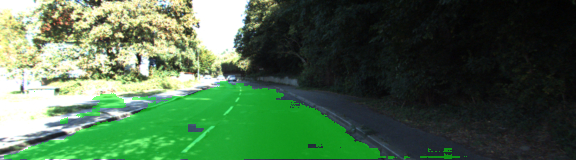

In [17]:
Image.open('./runs/1528573787.86253/um_000051.png')

In [0]:
!gsutil -m cp -r ./runs/1528573787.86253 gs://udacity-sdcnd-misc/fcn-project-outputs/lr0001-batch8-reg1e5-frozenvgg

In [22]:
!gsutil -m cp -r ./tensorboard_graphs/fcn gs://udacity-sdcnd-misc/fcn-project-outputs/lr0001-batch8-reg1e5-frozenvgg
!gsutil -m cp -r ./checkpoints gs://udacity-sdcnd-misc/fcn-project-outputs/lr0001-batch8-reg1e5-frozenvgg

Copying file://./tensorboard_graphs/fcn/events.out.tfevents.1528571817.80dec096c2ef [Content-Type=application/octet-stream]...
Copying file://./tensorboard_graphs/fcn/events.out.tfevents.1528572302.80dec096c2ef [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [2/2 files][  1.0 GiB/  1.0 GiB] 100% Done  73.6 MiB/s ETA 00:00:00 

\ [16/16 files][  5.7 GiB/  5.7 GiB] 100% Done 108.4 MiB/s ETA 00:00:00         
Operation completed over 16 objects/5.7 GiB.                                     


In [0]:
folderid = '1L26feQrmABeuxvvfxetFl5Wq5i82z7rl'
imgs = glob('./runs/1528461774.177817/*.png')
for idx, i in enumerate(imgs):
  file_metadata = {
    'name': os.path.basename(i),
    'parents':[folderid]
  }
  media = MediaFileUpload(i,
                        resumable=True)
  created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()

In [0]:
folderid_checkpoints = '1AfNuqwxKWY5kTu3T0M7YGPGFBPBD6bax'
files = glob('./checkpoints/fcn-reg-loss-39.*')
for idx, i in enumerate(files):
  file_metadata = {
    'name': os.path.basename(i),
    'parents':[folderid_checkpoints]
  }
  media = MediaFileUpload(i,
                        resumable=True)
  created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()

In [19]:
!ls ./checkpoints/


checkpoint			     fcn-reg-loss-37.index
fcn-reg-loss-35.data-00000-of-00001  fcn-reg-loss-37.meta
fcn-reg-loss-35.index		     fcn-reg-loss-38.data-00000-of-00001
fcn-reg-loss-35.meta		     fcn-reg-loss-38.index
fcn-reg-loss-36.data-00000-of-00001  fcn-reg-loss-38.meta
fcn-reg-loss-36.index		     fcn-reg-loss-39.data-00000-of-00001
fcn-reg-loss-36.meta		     fcn-reg-loss-39.index
fcn-reg-loss-37.data-00000-of-00001  fcn-reg-loss-39.meta


In [21]:
!ls ./tensorboard_graphs/fcn

events.out.tfevents.1528571817.80dec096c2ef
events.out.tfevents.1528572302.80dec096c2ef


In [14]:
!ls /tmp/tensorboard_graphs

ls: cannot access '/tmp/tensorboard_graphs': No such file or directory


In [15]:
!ls

checkpoints  datalab  ngrok-stable-linux-amd64.zip    runs
data	     ngrok    ngrok-stable-linux-amd64.zip.1  tensorboard_graphs
